In [251]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [252]:
df = pd.read_csv('data.csv')
#df.head()
df["xAttack"] = pd.Categorical(df["xAttack"])
df["xAttack"] = df["xAttack"].cat.codes
category=df['xAttack'].values
df=df.drop(['xAttack'], axis=1)
df.head()

,duration,service,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,25,193,441,0,0,0,0,0,0,...,15,255,1.00,0.00,0.07,0.04,0.00,0.04,0.0,0.0
1,0,38,0,0,0,0,0,0,0,0,...,255,1,0.00,0.07,0.00,0.00,0.00,0.00,1.0,1.0
2,0,25,167,9724,0,0,0,0,0,0,...,39,255,1.00,0.00,0.03,0.06,0.00,0.00,0.0,0.0
3,0,20,1339,0,0,0,0,0,0,0,...,134,31,0.23,0.04,0.23,0.00,0.02,0.00,0.0,0.0
4,0,37,0,0,0,0,0,0,0,0,...,255,25,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.0


In [253]:
data= df.values
print(data.shape)

(24998, 29)


In [254]:
category.shape

(24998,)

### Scaling Train and Test data for Neural Net

In [255]:
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)

maxs = np.amax(data, axis=0)
mins = np.amin(data, axis=0)


# Data used for autoencoder
AEdata = (data - mins) / (maxs - mins)
AEdata = AEdata.transpose()
X=AEdata

In [256]:
# No activation function
def linear(x):
    linear_grad = np.ones(x.shape)
    return x, linear_grad

# Sigmoid
def sigmoid(x):
    sigmoid = 1 / (1 + np.exp(-x))
    sigmoid_grad = sigmoid * (1 - sigmoid)
    return sigmoid, sigmoid_grad

# ReLU
def relu(x):
    relu = np.maximum(x, np.zeros(x.shape))
    relu_grad = np.ones(x.shape) * (x > 0)
    return relu, relu_grad

### Define the encoder dimension


In [257]:
# Make a new layer
def new_layer(dim_in, dim_out):
    weights = np.random.rand(dim_out, dim_in) - 0.5
    bias = np.random.rand(dim_out, 1) - 0.5
    
    return {
        'weights': weights,
        'bias': bias,
        'activations': np.zeros((dim_out, AEdata.shape[1])),
        'act_grad': np.zeros((dim_out, AEdata.shape[1])),
        'errors': np.zeros((dim_out, AEdata.shape[1])),
        'weights_grad': np.zeros(weights.shape),
        'bias_grad': np.zeros(bias.shape)
    }

# Our specific models hyperparameters
#def initialize_model():   return [new_layer(4, 3), new_layer(3, 2), new_layer(2, 3), new_layer(3, 4)]
# for autoencoder with multple hidden (bottlenexl layers)
def initialize_model():   return [new_layer(29,14),new_layer(14,29)]
def initialize_model_deep():   return [new_layer(29,20),new_layer(20,14)new_layer(14,20),new_layer(20,29)]

### Forward propagation

In [258]:
def forward_propagate(layers, inputs, activation_function):
    for layer in layers:
        zs = np.matmul(layer['weights'], inputs) + layer['bias']
        activations, act_grad = activation_function(zs)
        layer['activations'] = activations
        layer['act_grad'] = act_grad
        inputs = activations

In [259]:
def backward_propagate(layers, inputs, outputs):    
    # Initiate errors for the last layer (normalized)
    errors = (layers[-1]['activations'] - outputs)
    
    # Go backwards through the layers
    for layer_number, layer in reversed(list(enumerate(layers))):
        layer['errors'] = errors
        
        # Calculate Hadamard product between errors and activation gradients
        hadamard = errors * layer['act_grad']
        
        # Get activations of previous layer - if at the first layer use input
        if layer_number == 0:
            last_activations = inputs
        else:
            last_activations = layers[layer_number - 1]['activations']
        
        # Calculate derivatives of weights
        weights_grad = np.matmul(hadamard, last_activations.transpose()) / inputs.shape[1]
        layer['weights_grad'] = weights_grad
        
        # Calculate derivatives of biases
        bias_grad = hadamard.sum(axis=1).reshape(layer['bias'].shape) / inputs.shape[1]
        layer['bias_grad'] = bias_grad
        
        # Backpropagate errors, unless we're at the first layer
        if layer_number != 0:
            errors = np.matmul(layer['weights'].transpose(), hadamard)

In [260]:
def gradient_descent(layers, learning_rate):
    for layer in layers:
        layer['weights'] = layer['weights'] - layer['weights_grad'] * learning_rate
        layer['bias'] = layer['bias'] - layer['bias_grad'] * learning_rate

In [261]:
def error_function(layers):
    errors = layers[-1]['errors']
    e_squared = errors ** 2
    return e_squared.sum() / errors.shape[1]

In [262]:
def trainAE(activation_function, learning_rate, epochs):
    # Initialize model
    layers = initialize_model()
    
    # Array of errors
    error_history = []
    
    # Run through the epochs
    for epoch in range(epochs):
        forward_propagate(layers, AEdata, activation_function)
        backward_propagate(layers, AEdata, AEdata)
        gradient_descent(layers, learning_rate)
        error_history.append(error_function(layers))
    
    # Return trained model, and error_history for plotting
    return layers, error_history

In [343]:
def trainAE1(activation_function, learning_rate, epochs):
    # Initialize model
    layers = initialize_model_deep()
    
    # Array of errors
    error_history = []
    
    # Run through the epochs
    for epoch in range(epochs):
        forward_propagate(layers, AEdata, activation_function)
        backward_propagate(layers, AEdata, AEdata)
        gradient_descent(layers, learning_rate)
        error_history.append(error_function(layers))
    
    # Return trained model, and error_history for plotting
    return layers, error_history

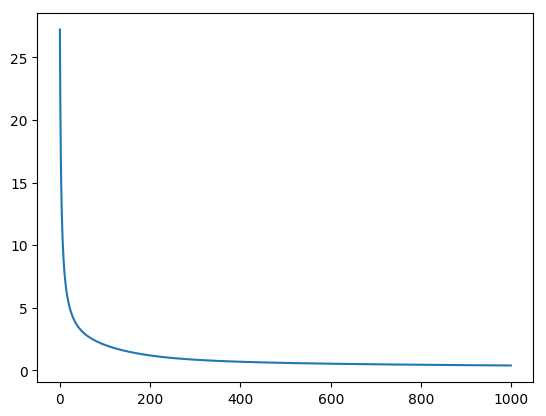

In [263]:
layers, error_history = trainAE(linear,0.01, 1000)

# Plot error history
plt.plot(range(1000), error_history)
plt.show()

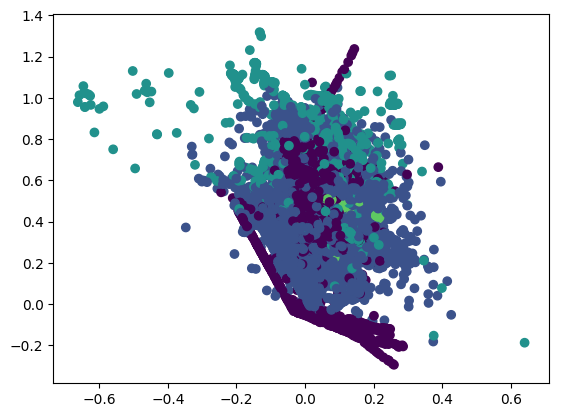

In [264]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=category)
plt.show()

### Autoencoder's data (For 1 hidden layer encoder) using linear function.

In [265]:
autoencoded_data= np.array(layers[1]['activations'])

In [266]:
autoencoded_data1=autoencoded_data.T
print(X.shape)

(29, 24998)


In [267]:
from numpy import linalg as LA
print(autoencoded_data1.shape)
total_loss=LA.norm((X.T-autoencoded_data1),None)
print (total_loss/10)

(24998, 29)
9.697362461767167


### Part 1: K-Means clustering

In [268]:
k = 5
from copy import deepcopy 
n = autoencoded_data1.shape[0]
c = autoencoded_data1.shape[1]
print(n,c)
mean = np.mean(autoencoded_data1, axis = 0)
std = np.std(autoencoded_data1, axis = 0)
centers = np.random.randn(k,c)*std + mean

24998 29


In [269]:
centers_old = np.zeros(centers.shape) 
centers_new = deepcopy(centers)

In [270]:
autoencoded_data1.shape
clusters = np.zeros(n)
distances = np.zeros((n,k))

In [271]:
error = np.linalg.norm(centers_new - centers_old)

In [272]:
while error != 0:
    for i in range(k):
        distances[:,i] = np.linalg.norm(autoencoded_data1 - centers[i], axis=1)
    clusters = np.argmin(distances, axis = 1)
    
    centers_old = deepcopy(centers_new)
    for i in range(k):
        centers_new[i] = np.mean(autoencoded_data1[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)
print(centers_new)
print(centers_new.shape)

[[ 2.41910831e-02  5.56767875e-01  1.89774296e-03  6.04421790e-03
   8.75929206e-03 -2.55882320e-03  9.99763118e-03  5.37646058e-04
   7.82774932e-04  1.43146171e-02  2.99476282e-01  4.22688274e-02
   6.13706512e-01  6.19348794e-01  2.04963870e-01  2.25504226e-01
   2.78595701e-01  9.79458302e-02  1.99312708e-02  9.26603419e-01
   8.25049972e-02  9.76644873e-02  1.44393216e-01  8.02547201e-02
   1.59766028e-02  6.20574125e-01  6.21834165e-01  2.02542274e-01
   2.09832346e-01]
 [ 5.23100972e-02  3.46408995e-01  2.09681430e-02 -9.18930582e-03
   4.99846712e-02 -7.92385289e-02 -7.36672244e-03 -3.88515956e-02
  -4.88007024e-02  4.04903201e-02  1.42514108e-01  8.02131609e-02
  -1.28510440e-01 -9.64106767e-02 -1.04719621e-01  1.23971294e-01
   7.86675063e-01  1.73307811e-01  1.77849706e-01  3.84298117e-01
   3.71323211e-01  5.41387558e-01  7.37665026e-02  4.57507047e-01
   3.56093222e-02 -1.55758311e-01 -3.82368953e-02 -1.51865491e-02
  -8.97749859e-02]
 [-3.87739614e-03  3.58705590e-01 -2.1

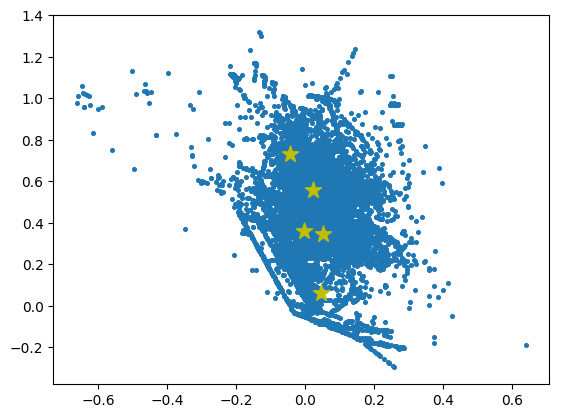

In [273]:
plt.scatter(autoencoded_data1[:,0], autoencoded_data1[:,1], s=7)
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='y', s=150)

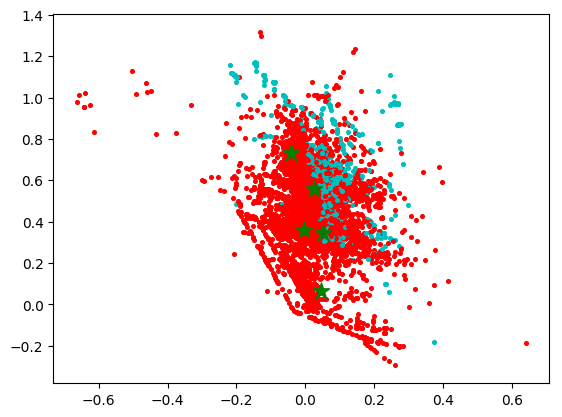

In [274]:
colors=10*['r', 'c', 'g','b','k']
n=autoencoded_data1.shape[0]
category=df.values[:,28]
for i in range(10000):
    plt.scatter(autoencoded_data1[i, 0], autoencoded_data1[i,1], s=7, color = colors[int(category[i])])
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)

In [275]:
clusters

array([2, 0, 2, ..., 0, 2, 0])

In [276]:
count=0
for i in range(len(clusters)):
    if clusters[i]==category[i]:
        if clusters[i]==0:
            count+=1
x=np.count_nonzero(clusters== 0)  
print (count/x)

0.778335535006605


In [277]:
count=1
for i in range(len(clusters)):
    if clusters[i]==category[i]:
        if clusters[i]==0:
            count+=1
x=np.count_nonzero(clusters== 0)  
print (count/x)

0.7784236019374725


In [278]:
from sklearn.metrics import accuracy_score
l_kmean=[]
def purity_score(y_true, y_pred):
   
    y_voted_labels = np.zeros(y_true.shape)
 
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
  
    labels = np.unique(y_true)

    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        
        
        winner = np.argmax(hist)
        c=np.count_nonzero(hist == winner)
        print (c/hist.size)
        l_kmean.append (c/hist.size)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)

In [279]:
purity_all=[]
pur_kmean=purity_score(category, clusters)
purity_all.append(pur_kmean)
pur_kmean
#category.shape

0.4444444444444444
0.6767676767676768
0.06060606060606061
0.9292929292929293
0.9797979797979798


0.8471477718217457

In [280]:
l_kmean

[0.4444444444444444,
 0.6767676767676768,
 0.06060606060606061,
 0.9292929292929293,
 0.9797979797979798]

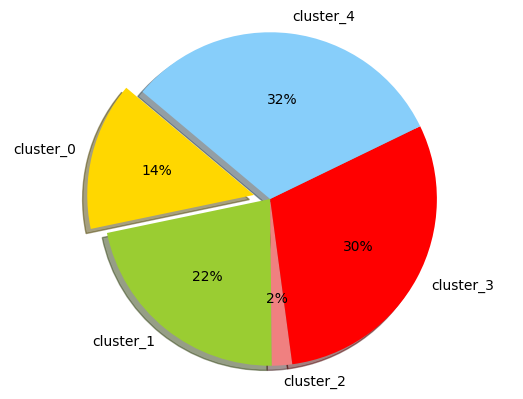

In [281]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = l_kmean
#print (len(l_kmean))
colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1,0,0,0,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.0f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 3 (Fitting reduced dimension data in Gaussian mixture model )

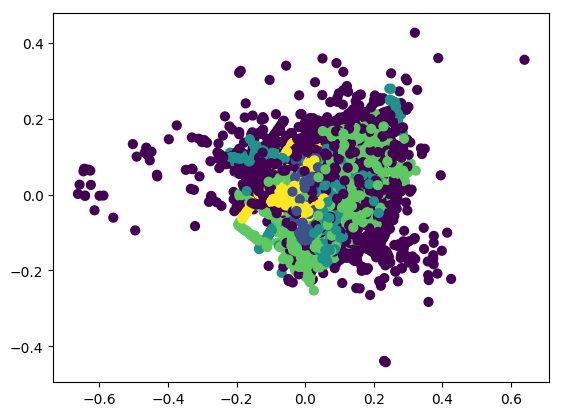

In [282]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5).fit(autoencoded_data1)
labels = gmm.predict(autoencoded_data1)
plt.scatter(autoencoded_data1[:, 0], autoencoded_data1[:, 5], c=labels, s=40, cmap='viridis');

### Getting purity of clusters

In [283]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

#category.shape

### Purity Calculation

In [284]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

x=purity_score(category, labels)
purity_all.append(x)

In [288]:
from sklearn.metrics import accuracy_score
purity_all=[]
l_gmm=[]
def purity_score(y_true, y_pred):
   
    y_voted_labels = np.zeros(y_true.shape)
 
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
  
    labels = np.unique(y_true)

    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        
        
        winner = np.argmax(hist)
        c=np.count_nonzero(hist == winner)
        print ("cluster",cluster,"->",c/hist.size)
        l_gmm.append (c/hist.size)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)


print ("Purity ",pur)
#category.shape

Purity  0.937555004400352


In [289]:
from sklearn.metrics import accuracy_score


pur=purity_score(category,labels)
purity_all.append(pur)
print ("Purity ",pur)
#category.shape

cluster 0 -> 0.0
cluster 1 -> 0.98989898989899
cluster 2 -> 0.0
cluster 3 -> 0.9696969696969697
cluster 4 -> 0.9696969696969697
Purity  0.937555004400352


In [290]:
l_gmm

[0.0, 0.98989898989899, 0.0, 0.9696969696969697, 0.9696969696969697]

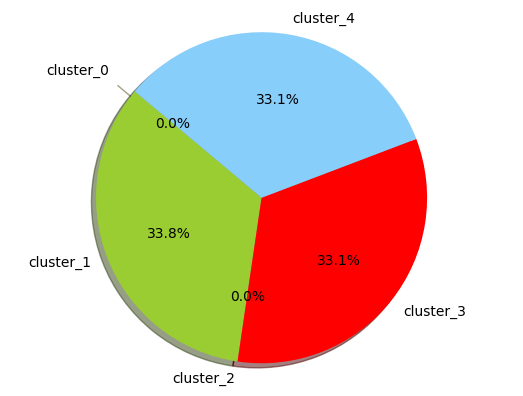

In [291]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = l_gmm

colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1, 0,0,0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 4: Hierarchical Clustering

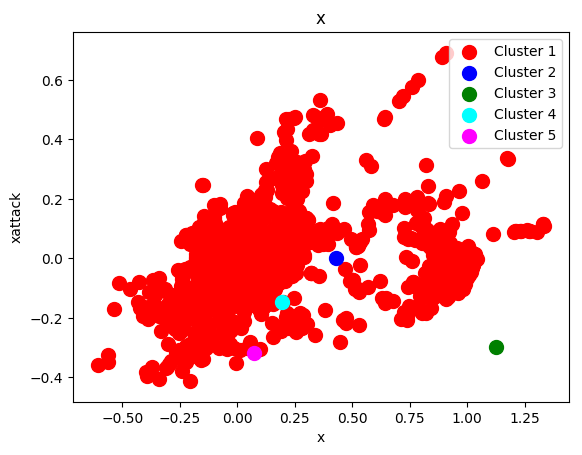

In [292]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'single')

autoencoded_data1=autoencoded_data1[0:10000,:]
y_hc = hc.fit_predict(autoencoded_data1)
# Visualising the clusters
plt.scatter(autoencoded_data1[y_hc == 0, 12], autoencoded_data1[y_hc == 0, 7], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(autoencoded_data1[y_hc == 1, 12], autoencoded_data1[y_hc == 1, 7], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(autoencoded_data1[y_hc == 2, 12], autoencoded_data1[y_hc == 2, 7], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(autoencoded_data1[y_hc == 3, 12], autoencoded_data1[y_hc == 3, 7], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(autoencoded_data1[y_hc == 4, 12], autoencoded_data1[y_hc == 4, 7], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('x')
plt.xlabel('x')
plt.ylabel('xattack')
plt.legend()
plt.show()


###  Single linkage variation

#### Euclidean distance

In [293]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
clusters=cluster.fit_predict(autoencoded_data1) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single Euclidean purity",purity_score(category[0:10000], clusters))


cluster 0 -> 0.0
cluster 1 -> 0.9885057471264368
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.0
Single Euclidean purity 0.8488


#### Manhattan Distance

In [294]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')  
clusters=cluster.fit_predict(autoencoded_data1) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single manhattan purity",purity_score(category[0:10000], clusters))

cluster 0 -> 0.0
cluster 1 -> 0.9885057471264368
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.9885057471264368
Single manhattan purity 0.8487


#### Cosine Distance


In [295]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='single')  
clusters=cluster.fit_predict(autoencoded_data1) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single cosine purity",purity_score(category[0:10000], clusters))

cluster 0 -> 0.011494252873563218
cluster 1 -> 0.0
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.9885057471264368
Single cosine purity 0.8488


### Single linkage variation

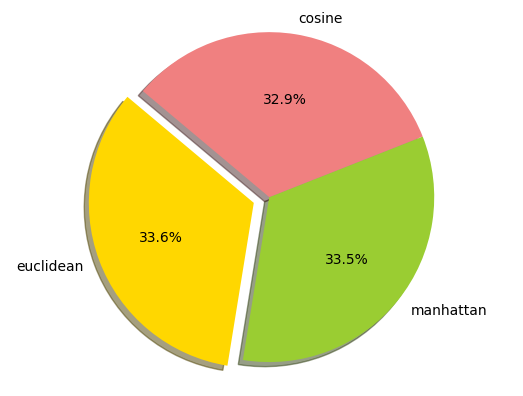

In [296]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'euclidean', 'manhattan', 'cosine'
sizes = [53.32, 53.3, 52.28]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


In [299]:
purity_all.append(0.535)
print(purity_all)

[0.937555004400352, 0.535, 0.535]


### Comparison of all clusterings

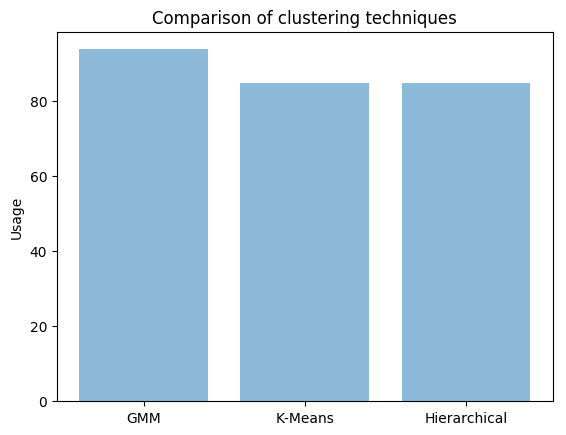

In [341]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('GMM', 'K-Means', 'Hierarchical')
y_pos = np.arange(len(objects))
performance = [93.75,84.71,84.77]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Comparison of clustering techniques')
 
plt.show()

## Sigmoid autoencoder (Non-Linear Function for 1 hidden layer)

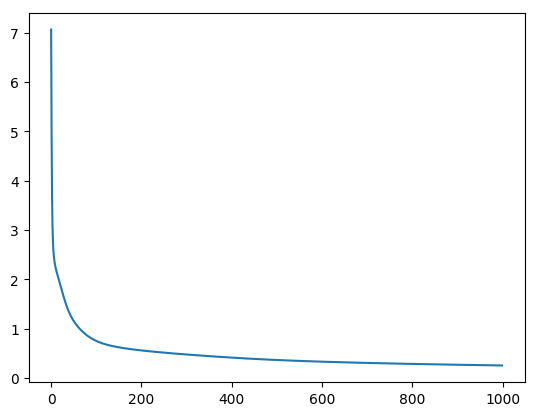

In [302]:
layers, error_history = trainAE(sigmoid, 1, 1000)

# Plot error history
plt.plot(range(1000), error_history)
plt.show()

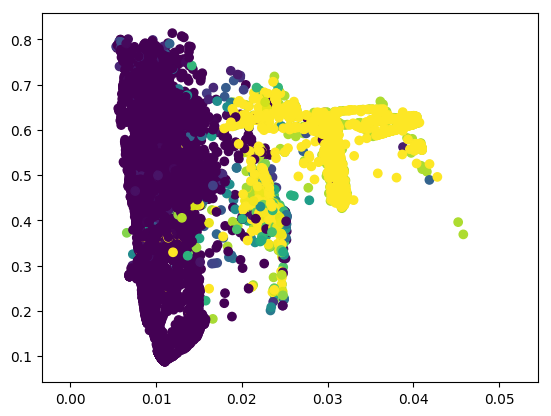

In [303]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=category)
plt.show()

In [304]:
autoencoded_data2= np.array(layers[1]['activations'])

In [305]:
autoencoded_data2=autoencoded_data2.T

### KMeans clustering on autoencoded data

In [309]:
k = 5
from copy import deepcopy 
n = autoencoded_data2.shape[0]
c = autoencoded_data2.shape[1]
print(n,c)
mean = np.mean(autoencoded_data2, axis = 0)
std = np.std(autoencoded_data2, axis = 0)
centers1 = np.random.randn(k,c)*std + mean

24998 29


In [310]:
centers_old1 = np.zeros(centers.shape) 
centers_new1 = deepcopy(centers)

In [311]:
autoencoded_data2.shape
clusters1 = np.zeros(n)
distances1 = np.zeros((n,k))

In [312]:
error1 = np.linalg.norm(centers_new1 - centers_old1)

In [313]:
while error1 != 0:
    for i in range(k):
        distances1[:,i] = np.linalg.norm(autoencoded_data2 - centers1[i], axis=1)
    clusters1 = np.argmin(distances1, axis = 1)
    
    centers_old1 = deepcopy(centers_new1)
    for i in range(k):
        centers_new1[i] = np.mean(autoencoded_data2[clusters1 == i], axis=0)
    error1 = np.linalg.norm(centers_new1 - centers_old1)
print(centers_new1)
print(centers_new1.shape)

[[0.01098905 0.44426957 0.00771548 0.00743967 0.00906544 0.00754303
  0.00662837 0.00893003 0.00690717 0.00848751 0.08334941 0.06941408
  0.06173618 0.05111819 0.05339134 0.05303377 0.90585625 0.04974873
  0.20843153 0.53736081 0.23745937 0.45801302 0.14032905 0.47752608
  0.07725586 0.05713165 0.0495773  0.06845508 0.05494245]
 [0.01206943 0.55356076 0.01311963 0.01287756 0.01285413 0.00813073
  0.01286851 0.01046188 0.01288858 0.01391131 0.33854617 0.03727094
  0.9545002  0.95357655 0.00645309 0.0040356  0.12035949 0.0936693
  0.02274741 0.96622443 0.04731993 0.02715715 0.0818872  0.02362412
  0.01651386 0.95487451 0.94891921 0.01158458 0.00457687]
 [0.01025085 0.34806445 0.00730114 0.00646115 0.0071936  0.00898453
  0.00755808 0.00812702 0.0065076  0.00763585 0.06470978 0.09193044
  0.02503003 0.02676219 0.05834618 0.05980967 0.9802393  0.02502174
  0.12166456 0.56049173 0.86640542 0.91799691 0.0368963  0.11907608
  0.05874328 0.02640343 0.01709691 0.06722034 0.05151482]
 [0.0302492

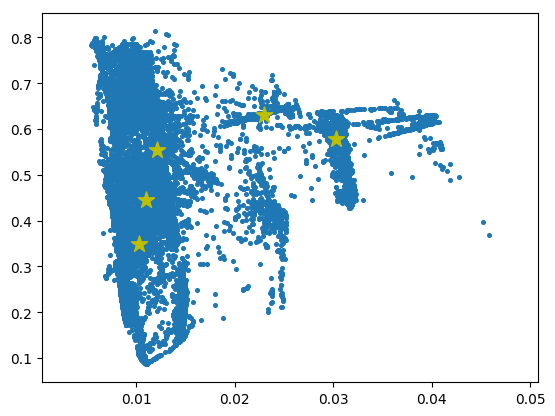

In [314]:
plt.scatter(autoencoded_data2[:,0], autoencoded_data2[:,1], s=7)
plt.scatter(centers_new1[:,0], centers_new1[:,1], marker='*', c='y', s=150)

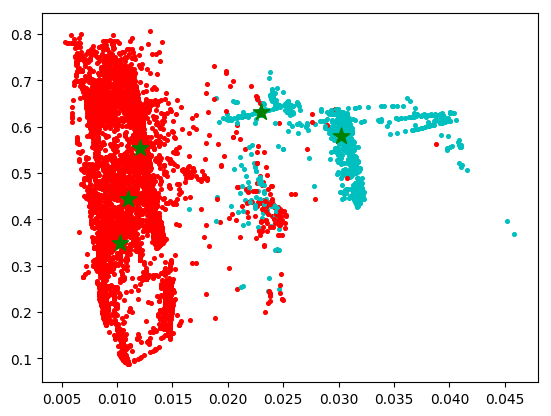

In [316]:
colors=10*['r', 'c', 'g','b','k']
n=autoencoded_data2.shape[0]
category=df.values[:,28]
for i in range(10000):
    plt.scatter(autoencoded_data2[i, 0], autoencoded_data2[i,1], s=7, color = colors[int(category[i])])
plt.scatter(centers_new1[:,0], centers_new1[:,1], marker='*', c='g', s=150)

In [318]:
purity_all=[]
pur_kmean=purity_score(category, clusters1)
purity_all.append(pur_kmean)
pur_kmean
#category.shape

cluster 0 -> 0.6464646464646465
cluster 1 -> 0.9494949494949495
cluster 2 -> 0.030303030303030304
cluster 3 -> 0.0
cluster 4 -> 0.0


0.9393951516121289

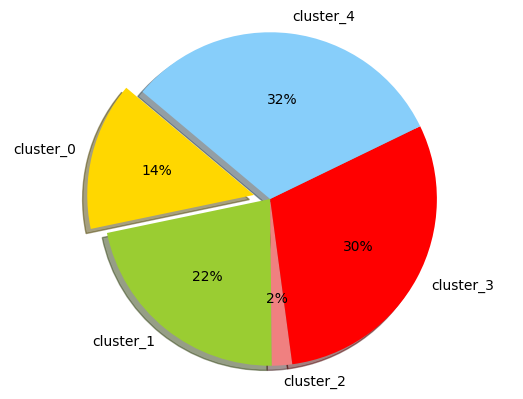

In [319]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = l_kmean
#print (len(l_kmean))
colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1, 0,0,0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.0f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 3 (Fitting reduced dimension data in Gaussian mixture model )

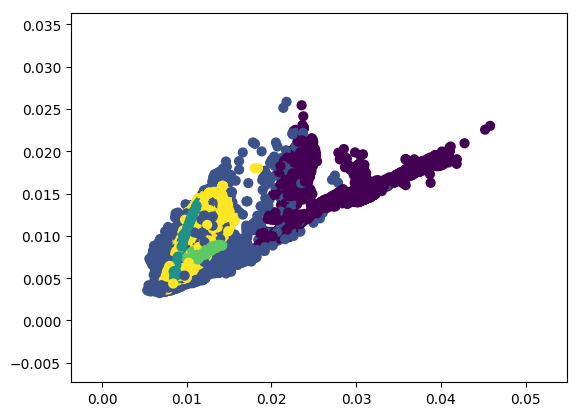

In [324]:
from sklearn.mixture import GaussianMixture
gmm1 = GaussianMixture(n_components=5).fit(autoencoded_data2)
labels1 = gmm1.predict(autoencoded_data2)
plt.scatter(autoencoded_data2[:, 0], autoencoded_data2[:, 5], c=labels, s=40, cmap='viridis');

### Getting purity of clusters

In [321]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

#category.shape

### Purity Calculation

In [325]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

x=purity_score(category, labels1)
purity_all.append(x)

In [329]:
from sklearn.metrics import accuracy_score
purity_all=[]
l_gmm1=[]
def purity_score(y_true, y_pred):
   
    y_voted_labels = np.zeros(y_true.shape)
 
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
  
    labels = np.unique(y_true)

    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        
        
        winner = np.argmax(hist)
        c=np.count_nonzero(hist == winner)
        print ("cluster",cluster,"->",c/hist.size)
        l_gmm1.append (c/hist.size)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)


print ("Purity ",pur)
#category.shape

Purity  0.9504360348827906


In [330]:
pur=purity_score(category,labels1)
purity_all.append(pur)
print ("Purity ",pur)
#category.shape

cluster 0 -> 0.898989898989899
cluster 1 -> 0.0
cluster 2 -> 0.98989898989899
cluster 3 -> 0.7070707070707071
cluster 4 -> 0.06060606060606061
Purity  0.9504360348827906


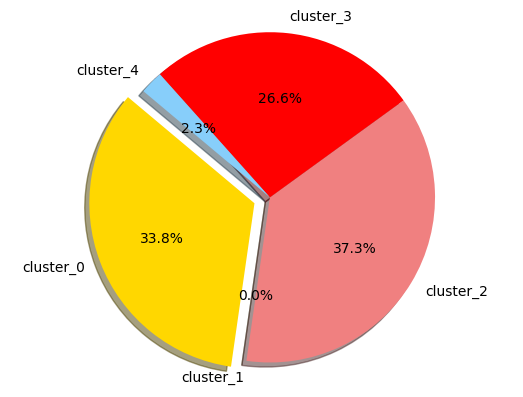

In [331]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = l_gmm1

colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1, 0,0,0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 4: Hierarchical Clustering

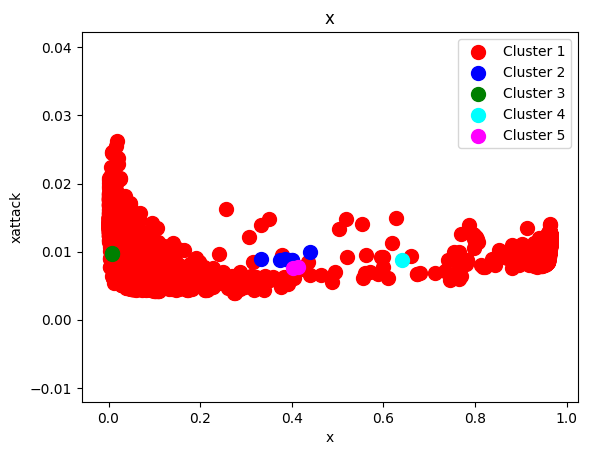

In [332]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'single')

autoencoded_data2=autoencoded_data2[0:10000,:]
y_hc = hc.fit_predict(autoencoded_data2)
# Visualising the clusters
plt.scatter(autoencoded_data2[y_hc == 0, 12], autoencoded_data2[y_hc == 0, 7], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(autoencoded_data2[y_hc == 1, 12], autoencoded_data2[y_hc == 1, 7], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(autoencoded_data2[y_hc == 2, 12], autoencoded_data2[y_hc == 2, 7], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(autoencoded_data2[y_hc == 3, 12], autoencoded_data2[y_hc == 3, 7], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(autoencoded_data2[y_hc == 4, 12], autoencoded_data2[y_hc == 4, 7], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('x')
plt.xlabel('x')
plt.ylabel('xattack')
plt.legend()
plt.show()


###  Single linkage variation


#### Euclidean distance

In [333]:
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
clusters2=cluster2.fit_predict(autoencoded_data2) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single Euclidean purity",purity_score(category[0:10000], clusters2))


cluster 0 -> 0.0
cluster 1 -> 0.9885057471264368
cluster 2 -> 0.0
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.9885057471264368
Single Euclidean purity 0.8489


### cosine Distance

In [334]:
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='single')  
clusters2=cluster2.fit_predict(autoencoded_data2) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single cosine purity",purity_score(category[0:10000], clusters2))

cluster 0 -> 0.0
cluster 1 -> 0.9885057471264368
cluster 2 -> 0.9770114942528736
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.9885057471264368
Single cosine purity 0.8487


### Manhattan distance 

In [336]:
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')  
clusters2=cluster.fit_predict(autoencoded_data2) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single manhattan purity",purity_score(category[0:10000], clusters2))

cluster 0 -> 0.0
cluster 1 -> 0.9885057471264368
cluster 2 -> 0.9770114942528736
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.9885057471264368
Single manhattan purity 0.8487


### Pie chart for single linkage 

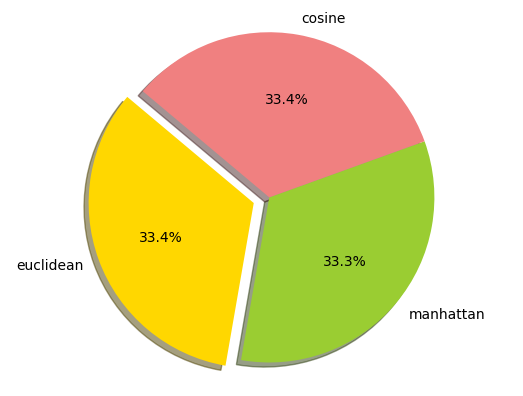

In [337]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'euclidean', 'manhattan', 'cosine'
sizes = [84.89,84.57, 84.87]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Comparison of all clustering methods

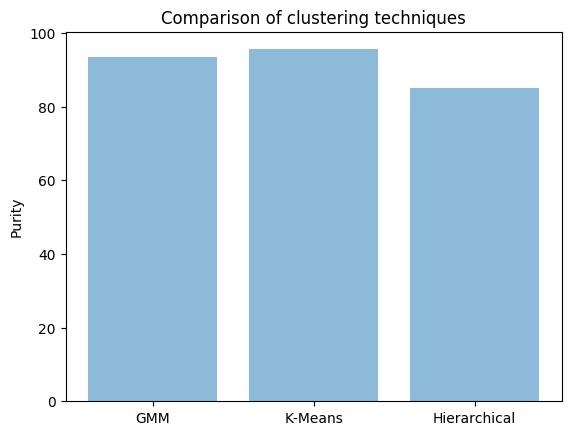

In [380]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('GMM', 'K-Means', 'Hierarchical')
y_pos = np.arange(len(objects))
performance = [93.33,95.53,84.89]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Purity')
plt.title('Comparison of clustering techniques')
 
plt.show()

## Autoencoder with multiple bottleneck layers and non-linear function (Sigmoid)

In [346]:
def initialize_model_deep():   
    return [new_layer(29,20),new_layer(20,14),new_layer(14,20),new_layer(20,29)]

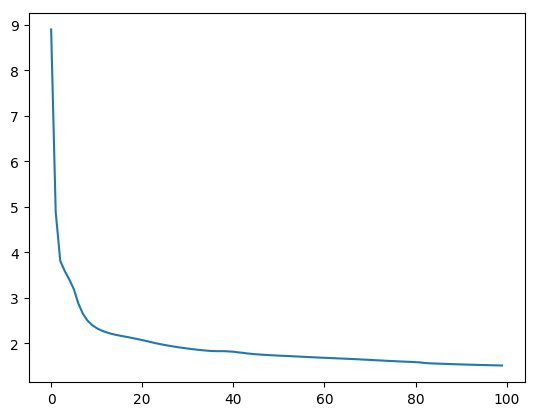

In [347]:
layers, error_history = trainAE1(relu, .1, 100)

# Plot error history
plt.plot(range(100), error_history)
plt.show()

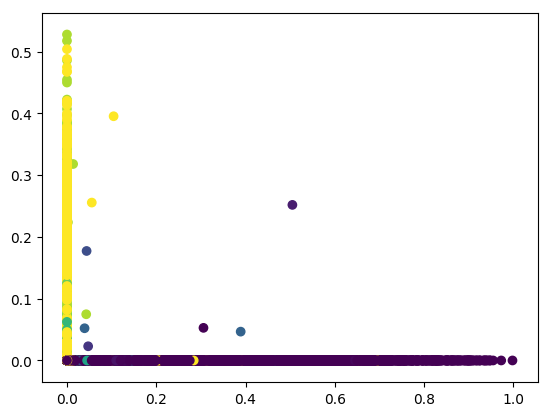

In [348]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=category)
plt.show()

In [354]:
autoencoded_data3= np.array(layers[1]['activations'])

In [355]:
print(autoencoded_data3.shape)
autoencoded_data3=autoencoded_data3.T
print(autoencoded_data3.shape)

(14, 24998)
(24998, 14)


### KMeans clustering with autoencoded data

In [356]:
k = 5
from copy import deepcopy 
n = autoencoded_data3.shape[0]
c = autoencoded_data3.shape[1]
print(n,c)
mean = np.mean(autoencoded_data3, axis = 0)
std = np.std(autoencoded_data3, axis = 0)
centers2 = np.random.randn(k,c)*std + mean

24998 14


In [357]:
centers_old2 = np.zeros(centers2.shape) 
centers_new2 = deepcopy(centers2)

In [358]:
autoencoded_data2.shape
clusters2 = np.zeros(n)
distances2 = np.zeros((n,k))

In [359]:
error2 = np.linalg.norm(centers_new2 - centers_old2)

In [360]:
while error2 != 0:
    for i in range(k):
        distances2[:,i] = np.linalg.norm(autoencoded_data3 - centers2[i], axis=1)
    clusters2 = np.argmin(distances2, axis = 1)
    
    centers_old2 = deepcopy(centers_new2)
    for i in range(k):
        centers_new2[i] = np.mean(autoencoded_data3[clusters2 == i], axis=0)
    error2 = np.linalg.norm(centers_new2 - centers_old2)
print(centers_new2)
print(centers_new2.shape)

[[6.93207429e-02 1.11802139e-02 3.38670152e-04 0.00000000e+00
  7.00144812e-01 0.00000000e+00 1.05129130e+00 4.06191237e-05
  7.70910226e-01 1.40600570e+00 0.00000000e+00 7.83615454e-01
  3.50804273e-01 4.05457012e-06]
 [3.02251480e-01 0.00000000e+00 3.25152027e-03 0.00000000e+00
  1.68990074e+00 0.00000000e+00 3.69160615e-01 0.00000000e+00
  9.76884598e-01 6.82570169e-01 3.23783855e-03 7.97528074e-02
  1.33712584e-01 7.25538862e-05]
 [3.48556173e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.18398062e+00 0.00000000e+00 9.93484513e-01 0.00000000e+00
  1.00297760e+00 3.05563855e-01 0.00000000e+00 1.27844555e-01
  6.35043543e-01 0.00000000e+00]
 [5.82363174e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.93668441e+00 0.00000000e+00 9.39989907e-01 0.00000000e+00
  7.75516590e-01 3.71932345e-01 0.00000000e+00 0.00000000e+00
  7.29835607e-01 0.00000000e+00]
 [2.90671800e-01 0.00000000e+00 3.87513342e-03 0.00000000e+00
  1.16162571e+00 2.84030487e-05 7.82009881e-01 3.24500902e-07


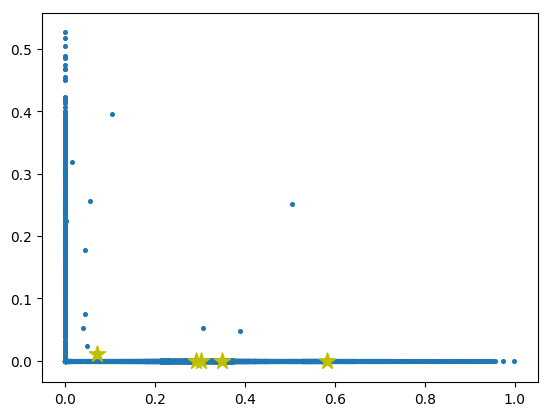

In [361]:
plt.scatter(autoencoded_data3[:,0], autoencoded_data3[:,1], s=7)
plt.scatter(centers_new2[:,0], centers_new2[:,1], marker='*', c='y', s=150)

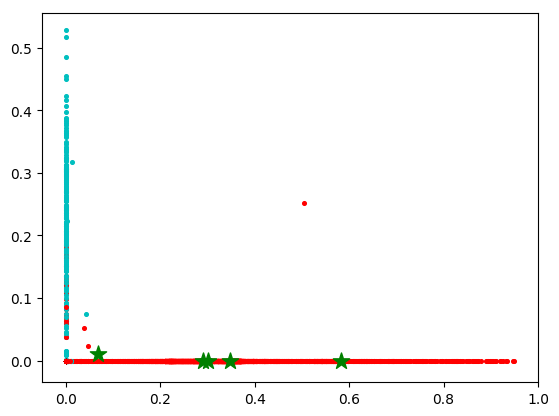

In [362]:
colors=10*['r', 'c', 'g','b','k']
n=autoencoded_data3.shape[0]
category=df.values[:,28]
for i in range(10000):
    plt.scatter(autoencoded_data3[i, 0], autoencoded_data3[i,1], s=7, color = colors[int(category[i])])
plt.scatter(centers_new2[:,0], centers_new2[:,1], marker='*', c='g', s=150)

In [363]:
purity_all=[]
pur_kmean=purity_score(category, clusters2)
purity_all.append(pur_kmean)
pur_kmean
#category.shape

cluster 0 -> 0.04040404040404041
cluster 1 -> 0.797979797979798
cluster 2 -> 0.8787878787878788
cluster 3 -> 0.9696969696969697
cluster 4 -> 0.6464646464646465


0.8471477718217457

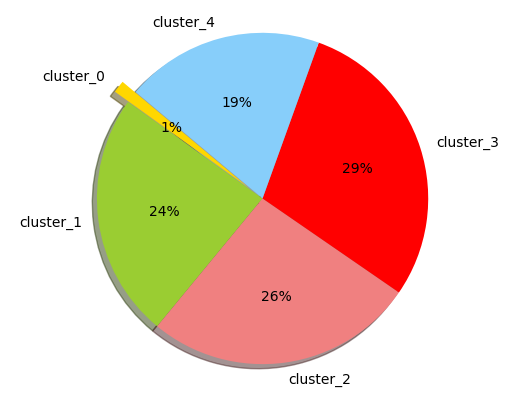

In [365]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = [0.04,0.7979,0.8787,0.9696,0.6464]
#print (len(l_kmean))
colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1, 0,0,0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.0f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 3: Using dimension reduced data for GMM clustering

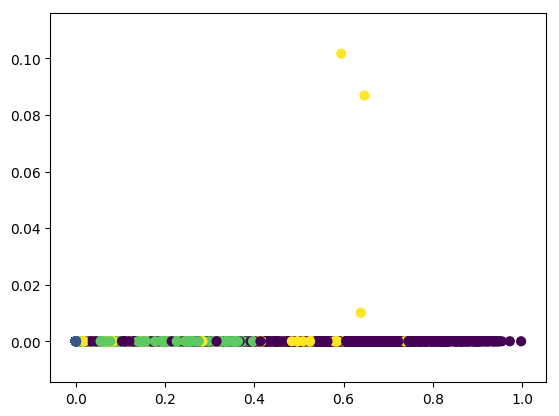

In [366]:
from sklearn.mixture import GaussianMixture
gmm2 = GaussianMixture(n_components=5).fit(autoencoded_data3)
labels2 = gmm2.predict(autoencoded_data3)
plt.scatter(autoencoded_data3[:, 0], autoencoded_data3[:, 5], c=labels2, s=40, cmap='viridis');

### Getting Purity of clusters

In [368]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

#category.shape

### Getting purity of clusters

In [371]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

x=purity_score(category, labels2)
purity_all.append(x)

In [377]:
from sklearn.metrics import accuracy_score
purity_all=[]
l_gmm2=[]
def purity_score(y_true, y_pred):
   
    y_voted_labels = np.zeros(y_true.shape)
 
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
  
    labels = np.unique(y_true)

    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        
        
        winner = np.argmax(hist)
        c=np.count_nonzero(hist == winner)
        print ("cluster",cluster,"->",c/hist.size)
        l_gmm2.append (c/hist.size)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)


In [378]:
pur=purity_score(category,labels2)
purity_all.append(pur)
print ("Purity ",pur)

cluster 0 -> 0.35353535353535354
cluster 1 -> 0.98989898989899
cluster 2 -> 0.0
cluster 3 -> 0.8686868686868687
cluster 4 -> 0.32323232323232326
Purity  0.951076086086887


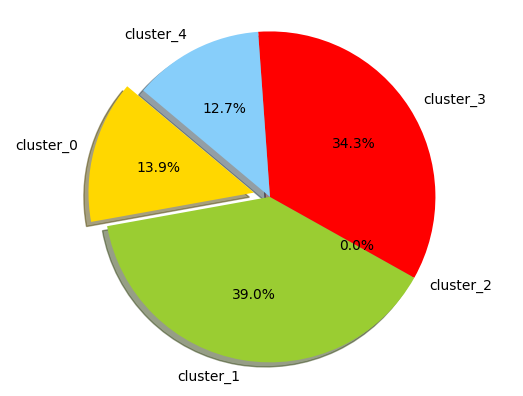

In [379]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'cluster_0', 'cluster_1', 'cluster_2','cluster_3','cluster_4'
sizes = l_gmm2

colors = ['gold', 'yellowgreen', 'lightcoral','red','lightskyblue']
explode = (0.1, 0,0,0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Part 4: Hierarchical Clustering

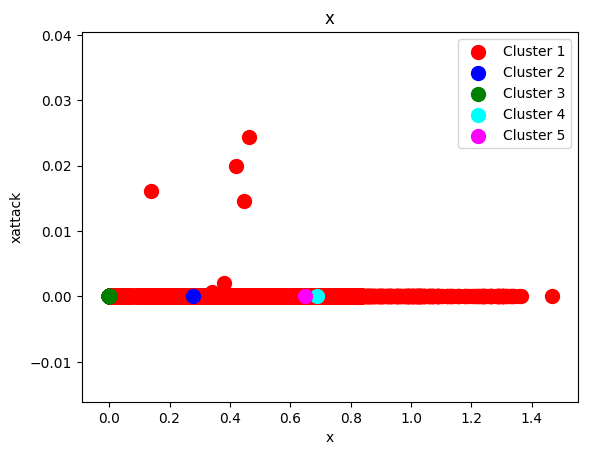

In [381]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'single')

autoencoded_data3=autoencoded_data3[0:10000,:]
y_hc = hc.fit_predict(autoencoded_data3)
# Visualising the clusters
plt.scatter(autoencoded_data3[y_hc == 0, 12], autoencoded_data3[y_hc == 0, 7], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(autoencoded_data3[y_hc == 1, 12], autoencoded_data3[y_hc == 1, 7], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(autoencoded_data3[y_hc == 2, 12], autoencoded_data3[y_hc == 2, 7], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(autoencoded_data3[y_hc == 3, 12], autoencoded_data3[y_hc == 3, 7], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(autoencoded_data3[y_hc == 4, 12], autoencoded_data3[y_hc == 4, 7], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('x')
plt.xlabel('x')
plt.ylabel('xattack')
plt.legend()
plt.show()


### Single linkage variation

#### Euclidean distance

In [383]:
from sklearn.cluster import AgglomerativeClustering

cluster3 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')  
clusters3=cluster3.fit_predict(autoencoded_data3) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single Euclidean purity",purity_score(category[0:10000], clusters3))


cluster 0 -> 0.0
cluster 1 -> 0.0
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.0
Single Euclidean purity 0.8489


#### Cosine distance

In [384]:
from sklearn.cluster import AgglomerativeClustering

cluster3 = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='single')  
clusters3=cluster3.fit_predict(autoencoded_data3) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single cosine purity",purity_score(category[0:10000], clusters3))

cluster 0 -> 0.0
cluster 1 -> 0.0
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.0
Single cosine purity 0.8489


#### Manhattan distance

In [385]:
from sklearn.cluster import AgglomerativeClustering

cluster3 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')  
clusters3=cluster.fit_predict(autoencoded_data3) 
#print (category.shape,clusters.shape,X_train_pca.shape)
print ("Single manhattan purity",purity_score(category[0:10000], clusters3))

cluster 0 -> 0.0
cluster 1 -> 0.0
cluster 2 -> 0.9885057471264368
cluster 3 -> 0.9885057471264368
cluster 4 -> 0.0
Single manhattan purity 0.8489


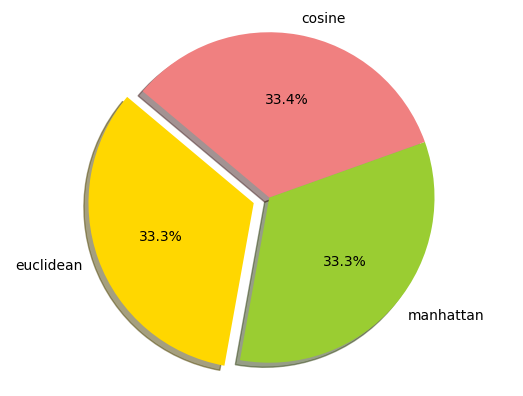

In [386]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'euclidean', 'manhattan', 'cosine'
sizes = [84.49,84.57, 84.89]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0,  0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


### Comparison of all clusering methods

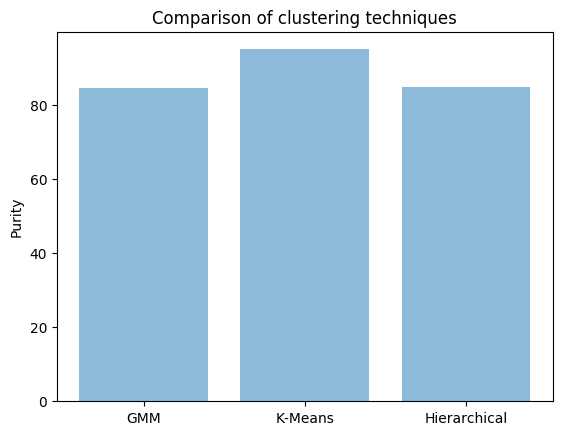

In [388]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('GMM', 'K-Means', 'Hierarchical')
y_pos = np.arange(len(objects))
performance = [84.74,95.10,84.89]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Purity')
plt.title('Comparison of clustering techniques')
 
plt.show()

### ReLU autoencoder


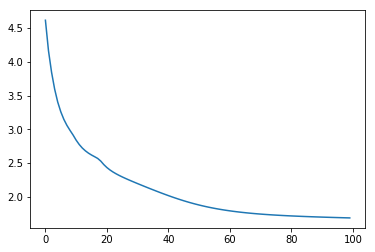

In [112]:
layers, error_history = trainAE(relu, .1, 100)

# Plot error history
plt.plot(range(100), error_history)
plt.show()

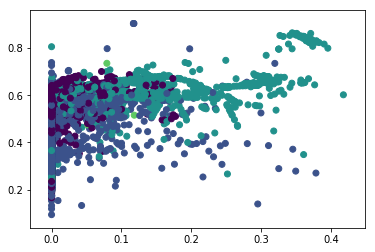

In [113]:
# Get encoded coordinates
ec1 = np.array(layers[1]['activations'][0, :].transpose())
ec2 = np.array(layers[1]['activations'][1, :].transpose())

# Plot encoded data
plt.scatter(ec1, ec2, c=category)
plt.show()

In [ ]:
autoencoded_data2= np.array(layers[1]['activations'])
autoencoder_data2=autoencoder_data2.T